In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Activation, Input, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from keras.models import load_model

## data load

In [41]:
dataset = pd.read_csv('./data_feature_mfcc20.csv')
print(dataset[:5])
print(dataset.index)
feature = []
for idx in dataset.index:
    feature.append(list(map(float, dataset.iloc[idx, 2].split(', '))))
print(len(feature))


   gender  language                                            feature
0       0         0  -43.007637, -43.007637, -43.007637, -43.007637...
1       0         0  -43.005123, -41.460415, -38.621128, -37.740406...
2       0         0  -39.88351, -39.199074, -38.777107, -41.36376, ...
3       0         0  -43.11376, -41.95098, -38.71098, -38.10872, -3...
4       0         0  -42.62169, -42.62169, -42.62169, -42.62169, -4...
RangeIndex(start=0, stop=42068, step=1)
42068


In [42]:
X = feature
Y = dataset['gender']

y_data = to_categorical(Y, num_classes=2)

x = np.array(X).astype('float32')
y = np.array(y_data)
print(x.shape, y.shape)
print(x[:10])
print(y[:10])

(42068, 108) (42068, 2)
[[-43.007637 -43.007637 -43.007637 ... -41.724716 -41.208908 -40.83515 ]
 [-43.005123 -41.460415 -38.621128 ... -43.005123 -43.005123 -43.005123]
 [-39.88351  -39.199074 -38.777107 ... -42.79019  -42.79019  -42.79019 ]
 ...
 [-45.159256 -45.159256 -45.159256 ... -36.782803 -38.635868 -39.360126]
 [-45.294586 -43.634083 -42.126347 ... -39.67121  -41.439278 -45.294586]
 [-43.625343 -40.204887 -40.095592 ... -44.909782 -41.995636 -43.011883]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.25, shuffle=True)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(31551, 108) (31551, 2)
(10517, 108) (10517, 2)


## train

### CNN model

In [46]:
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
print(x_traincnn.shape, x_testcnn.shape)

(31551, 108, 1) (10517, 108, 1)


In [50]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same', input_shape=(108,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))
opt = tf.keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

C:\Users\mjw27\Anaconda3\envs\voice\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [51]:
model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])

In [52]:
callback = [ModelCheckpoint('model_cnn_256.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), 
EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')]

cnnhistory=model.fit(x_traincnn[:10], y_train[:10], batch_size=256, epochs=800, validation_data=(x_testcnn[:10], y_test[:10]), callbacks=callback)

Epoch 1/800
1/1 [==============================] - ETA: 0s - loss: 0.7294 - accuracy: 0.6000
Epoch 00001: val_loss improved from inf to 0.71765, saving model to model_cnn_256.h5
1/1 [==============================] - 10s 10s/step - loss: 0.7294 - accuracy: 0.6000 - val_loss: 0.7177 - val_accuracy: 0.6000
Epoch 2/800
1/1 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.4000
Epoch 00002: val_loss improved from 0.71765 to 0.70986, saving model to model_cnn_256.h5
1/1 [==============================] - 0s 175ms/step - loss: 0.7054 - accuracy: 0.4000 - val_loss: 0.7099 - val_accuracy: 0.6000
Epoch 3/800
1/1 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.5000
Epoch 00003: val_loss improved from 0.70986 to 0.70530, saving model to model_cnn_256.h5
1/1 [==============================] - 0s 161ms/step - loss: 0.6899 - accuracy: 0.5000 - val_loss: 0.7053 - val_accuracy: 0.6000
Epoch 4/800
1/1 [==============================] - ETA: 0s - loss: 0.683

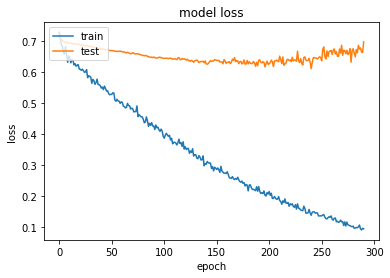

In [55]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## test

In [60]:
gender = ['man', 'woman']

loaded_model = load_model('model_cnn_mfcc20_256.h5')
data, sr = librosa.load('ex_data/output10.wav', duration=2.5, offset=0)
mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=20), axis=0)
mfcc = pd.DataFrame(data=mfccs)
mfcc = mfcc.stack().to_frame().T
print(mfcc.shape)

twodim = np.expand_dims(mfcc, axis=2)
print(twodim.shape)

(1, 108)
(1, 108, 1)


In [61]:
result = loaded_model.predict(twodim, batch_size=256, verbose=1)
label = int(result.argmax(axis=1))
print(f"predict gender: {gender[label]}")

1/1 [==============================] - 0s 106ms/step
predict gender: man


## h5 to onnx

In [ ]:
import tensorflow as tf
from keras.models import load_model
import tf2onnx

model = load_model("model_cnn_mfcc20_256.h5")
tf.saved_model.save(model, "tmp_model")

# cmd창에서
python -m tf2onnx.convert --saved-model tmp_model --output model.onnx